# Dependencies

In [ ]:
import pkg_resources
import sys
import subprocess

# List of required packages (use package names as recognized by pip)
required = {
    'geopandas',
    'osmnx',
    'contextily',
    'libpysal',
    'esda',
    'pointpats',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'geodatasets',
    'folium'
}

# Get the set of installed packages
installed = {pkg.key for pkg in pkg_resources.working_set}
# Determine which packages are missing
missing = required - installed

if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages are already installed.")

# Python imports

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
from shapely.geometry import Point, Polygon, shape
from shapely.wkt import loads
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from sklearn.cluster import DBSCAN, KMeans
import os
import warnings
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import contextily as ctx
import libpysal
import esda

# Data collection

In [ ]:
# use this to get data from cityofnewyork.us
def load_data(url, filename, usecols=None):
    """
    Downloads a CSV file from a given URL and loads it into a DataFrame.
    """
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        df = pd.read_csv(url, usecols=usecols)
        df.to_csv(filename, index=False)
    else:
        print(f"Loading {filename} from local file...")
        df = pd.read_csv(filename, usecols=usecols)
    return df

## Crime data

In [ ]:
crime_data_path = "./data/NYPD_Complaint_Data_Historic.csv"
crime_data_url = "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"
crime_cols = ["CMPLNT_FR_DT", "LAW_CAT_CD", "BORO_NM", "ADDR_PCT_CD", "Latitude", "Longitude"]

crime_df = load_data(crime_data_url, crime_data_path, usecols=crime_cols)

# Convert dates to datetime. Parse errors will set value to NaT
crime_df["CMPLNT_FR_DT"] = pd.to_datetime(crime_df["CMPLNT_FR_DT"], format="%m/%d/%Y", errors='coerce')

# Filter for year 2019
crime_df = crime_df[crime_df["CMPLNT_FR_DT"].dt.year == 2019]

# Drop records with missing or invalid coordinates
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])
crime_df = crime_df[crime_df["Latitude"] != 0]

# convert to geodataframe
crime_gdf = gpd.GeoDataFrame(
    crime_df,
    geometry=gpd.points_from_xy(crime_df["Longitude"], crime_df["Latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

print(f"Total records in 2019: {len(crime_df)}")
crime_gdf.head(3)

## Population by Neighbourhood tabulation areas (NTA) data

In [ ]:
import geopandas as gpd
import pandas as pd
import re
from shapely.wkt import loads
from difflib import SequenceMatcher
from IPython.display import Markdown, display

# ——————————————————————————————————————————————————————————————
# 0) Assumes `load_data(url, path)` is defined elsewhere
# ——————————————————————————————————————————————————————————————

# 1) Load NTA polygons
nta_polys_data_path = "./data/NYC_NTA_Polygons.csv"
nta_polys_data_url  = "https://data.cityofnewyork.us/api/views/9nt8-h7nd/rows.csv?accessType=DOWNLOAD"
nta_polys_df = load_data(nta_polys_data_url, nta_polys_data_path)

# 2) Convert to GeoDataFrame (EPSG:4326 → EPSG:3857)
nta_polys_gdf = gpd.GeoDataFrame(
    nta_polys_df,
    geometry=nta_polys_df["the_geom"].apply(loads),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# 3) Load NTA population table
nta_pop_data_path = "./data/NYC_NTA.csv"
nta_pop_data_url  = "https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD"
nta_pop_df = load_data(nta_pop_data_url, nta_pop_data_path)

# 4) Normalize population DataFrame columns
nta_pop_df = nta_pop_df.rename(columns={
    "NTA Code":   "NTA2020",
    "Population": "population",
    "NTA Name":   "NTAName_pop"
})

# 5) Merge on NTA2020 code
nta_polys_gdf = nta_polys_gdf.merge(
    nta_pop_df[["NTA2020", "population"]],
    on="NTA2020",
    how="left"
)

# 6) Exact‐name fallback
nta_pop_df["NTAName_lc"]    = nta_pop_df["NTAName_pop"].str.lower()
nta_polys_gdf["NTAName_lc"] = nta_polys_gdf["NTAName"].str.lower()
pop_lookup = nta_pop_df.set_index("NTAName_lc")["population"].to_dict()
mask_missing = nta_polys_gdf["population"].isna()
nta_polys_gdf.loc[mask_missing, "population"] = (
    nta_polys_gdf.loc[mask_missing, "NTAName_lc"].map(pop_lookup)
)
nta_polys_gdf = nta_polys_gdf.drop(columns="NTAName_lc")

# 7) Record initial unmatched set
initial_unmatched = nta_polys_gdf[nta_polys_gdf["population"].isna()].copy()
initial_count     = len(initial_unmatched)

# 8) Helpers for fuzzy matching
def normalize_string(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9 ]+', ' ', s).strip().lower()

def common_prefix_len(a: str, b: str) -> int:
    for i in range(min(len(a), len(b))):
        if a[i] != b[i]:
            return i
    return min(len(a), len(b))

def substring_match_len(a: str, b: str) -> int:
    matcher = SequenceMatcher(None, a, b)
    match   = matcher.find_longest_match(0, len(a), 0, len(b))
    return match.size

pop_names   = nta_pop_df["NTAName_pop"].tolist()
name_to_pop = nta_pop_df.set_index("NTAName_pop")["population"].to_dict()

# 9) Compute best matches & confidences
records = []
for raw in initial_unmatched["NTAName"]:
    norm_raw = normalize_string(raw)
    best_pref, best_sub, best_glob = None, None, None
    score_pref, score_sub, score_glob = -1.0, -1.0, -1.0
    for cand in pop_names:
        norm_cand = normalize_string(cand)
        p = common_prefix_len(norm_raw, norm_cand) / (len(norm_cand) or 1)
        if p > score_pref:
            score_pref, best_pref = p, cand
        s = substring_match_len(norm_raw, norm_cand) / (len(norm_cand) or 1)
        if s > score_sub:
            score_sub, best_sub = s, cand
        g = SequenceMatcher(None, norm_raw, norm_cand).ratio()
        if g > score_glob:
            score_glob, best_glob = g, cand
    records.append({
        "Unmatched NTA Name":   raw,
        "Prefix Match":         best_pref,
        "Prefix Confidence":    score_pref,
        "Prefix Population":    name_to_pop[best_pref],
        "Substring Match":      best_sub,
        "Substring Confidence": score_sub,
        "Substring Population": name_to_pop[best_sub],
        "Overall Match":        best_glob,
        "Overall Confidence":   score_glob,
        "Overall Population":   name_to_pop[best_glob],
    })

matches_df = pd.DataFrame(records)

# 10) Prefill any 100% matches
filled_by_prefix    = set()
filled_by_substring = set()
filled_by_overall   = set()
for _, r in matches_df.iterrows():
    nm = r["Unmatched NTA Name"]
    if r["Prefix Confidence"] == 1.0:
        nta_polys_gdf.loc[nta_polys_gdf["NTAName"]==nm, "population"] = r["Prefix Population"]
        filled_by_prefix.add(nm)
    elif r["Substring Confidence"] == 1.0:
        nta_polys_gdf.loc[nta_polys_gdf["NTAName"]==nm, "population"] = r["Substring Population"]
        filled_by_substring.add(nm)
    elif r["Overall Confidence"] == 1.0:
        nta_polys_gdf.loc[nta_polys_gdf["NTAName"]==nm, "population"] = r["Overall Population"]
        filled_by_overall.add(nm)

# 11) Prefill by global≥0.80 & (prefix or substring)≥0.45 same candidate
filled_by_fallback = set()
for _, r in matches_df.iterrows():
    nm = r["Unmatched NTA Name"]
    if pd.isna(nta_polys_gdf.loc[nta_polys_gdf["NTAName"]==nm, "population"]).any():
        cond = (
            r["Overall Confidence"] >= 0.80
            and (
                (r["Overall Match"]==r["Prefix Match"]    and r["Prefix Confidence"]>=0.45)
             or (r["Overall Match"]==r["Substring Match"] and r["Substring Confidence"]>=0.45)
            )
        )
        if cond:
            nta_polys_gdf.loc[nta_polys_gdf["NTAName"]==nm, "population"] = r["Overall Population"]
            filled_by_fallback.add(nm)

# 12) Final still‐missing
still_unmatched = nta_polys_gdf[nta_polys_gdf["population"].isna()]
final_count     = len(still_unmatched)
matched_count   = initial_count - final_count

# 13) Display table if needed
if final_count:
    disp = matches_df.loc[
        matches_df["Unmatched NTA Name"].isin(still_unmatched["NTAName"])
    ].copy()
    # strip special chars in display
    for c in ["Unmatched NTA Name","Prefix Match","Substring Match","Overall Match"]:
        disp[c] = disp[c].str.replace(r'[^A-Za-z0-9 ]+', ' ', regex=True).str.strip()
    display(Markdown(
        "## NTAs Still Missing Population\n\n"
        + disp[[
            "Unmatched NTA Name",
            "Prefix Match","Prefix Confidence","Prefix Population",
            "Substring Match","Substring Confidence","Substring Population",
            "Overall Match","Overall Confidence","Overall Population"
          ]].to_markdown(index=False)
    ))

# 14) Print summary
print(f"Total NTAs processed:             {len(nta_polys_gdf)}")
print(f"NTAs initially missing population: {initial_count}")
print(f"  • Filled by 100% prefix match:   {len(filled_by_prefix)}")
print(f"  • Filled by 100% substring match:{len(filled_by_substring)}")
print(f"  • Filled by 100% overall match:  {len(filled_by_overall)}")
print(f"  • Filled by fallback (80%+ & 45%+): {len(filled_by_fallback)}")
print(f"NTAs still missing population:     {final_count}")
if final_count == 0:
    print("✅ All NTAs now have a population value.")


## PROBLEM MED OVENSTÅENDE STRING MATCH

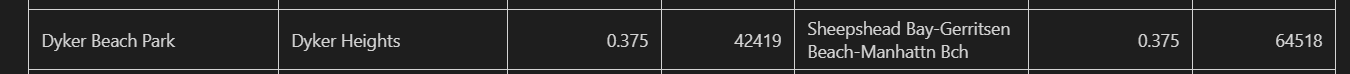

- Nogle har ikke et godt match.

- Nogle får også et match grundet "BlaBlaBlaBla-South" får en høj prefix confidence på "BlaBlaBlaBla-North"

## Amenities data

In [ ]:
amenities_data_path = "./data/NYC_Amenities.csv"

# Function to extract coordinates from Point objects or calculate centroid for Polygons
def extract_coordinates(geometry):
    if isinstance(geometry, Point):
        return geometry.x, geometry.y
    elif isinstance(geometry, Polygon):
        centroid = geometry.centroid
        return centroid.x, centroid.y
    return None, None

amenities_df = None
amenities_gdf = None

# Apply the function to the dataset
if os.path.exists(amenities_data_path):
    print("Loading amenities data from local file...")
    amenities_df = pd.read_csv(amenities_data_path, low_memory=False)
    # convert to geodataframe
    amenities_gdf = gpd.GeoDataFrame(
        amenities_df,
        geometry=amenities_df["geometry"].apply(loads),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
else:
    print("Querying OSM for amenities data...")
    # Define a dictionary of tags for the amenities you're interested in
    tags = {
        "amenity": ["bar", "restaurant"],
        "leisure": "park",
        "railway": "station"
    }

    # Use OSMnx to query OSM for these features in New York City
    amenities_gdf = ox.features.features_from_place("New York City, USA", tags)

    # Extract coordinates or calculate centroid
    amenities_gdf[['Longitude', 'Latitude']] = amenities_gdf['geometry'].apply(lambda x: pd.Series(extract_coordinates(x)))

    # Save the queried data to a CSV file for future use
    amenities_gdf.to_csv(amenities_data_path, index=False)
    amenities_df = amenities_gdf

# Create a new column 'category' to combine 'leisure' and 'amenity'
amenities_gdf['category'] = amenities_gdf['leisure'].combine_first(amenities_gdf['amenity']).combine_first(amenities_gdf['railway'])

# 5) Filter to exactly the four types you want
keep = ["bar", "restaurant", "park", "station"]
amenities_gdf = amenities_gdf[amenities_gdf["category"].isin(keep)]

for amenity in amenities_gdf['category'].unique():
    print(f"Number of {amenity}: {len(amenities_gdf[amenities_gdf['category'] == amenity])}")
    


# VISUALIZATION

## TABLES

In [ ]:
from IPython.display import display, Markdown
import numpy as np

def preview_gdf(
    gdf, 
    name, 
    groupby=None, 
    max_groups=None, 
    cols=None, 
    n=5, 
    random_state=42
):
    """
    Preview a GeoDataFrame in Markdown:
    - Reprojects to WGS84 (lat/lon).
    - Computes 'Latitude'/'Longitude' from centroids.
    - Always shows the 'geometry' column.
    - If `groupby` is provided, samples 1 row per group (up to max_groups).
      Otherwise, shows the first n rows.
    - You can pass `cols` to include extra columns before geometry/lat/lon.
    """
    # 1) Copy and reproject
    df = gdf.copy().to_crs(epsg=4326)
    # 2) Compute lat/lon
    centroids = df.geometry.centroid
    df['Latitude']  = centroids.y
    df['Longitude'] = centroids.x

    # 3) Decide rows to show
    if groupby:
        groups = df[groupby].dropna().unique()
        if max_groups and len(groups) > max_groups:
            rng = np.random.default_rng(random_state)
            groups = rng.choice(groups, size=max_groups, replace=False)
        df = (
            df[df[groupby].isin(groups)]
            .groupby(groupby, group_keys=False)
            .apply(lambda sub: sub.sample(n=1, random_state=random_state))
            .reset_index(drop=True)
        )
        title = f"{name} — Representative (1 per '{groupby}')"
    else:
        df = df.head(n)
        title = f"{name} — Sample ({n} rows)"

    # 4) Build column list: user cols + geometry + lat/lon
    display_cols = []
    if cols:
        display_cols += cols
    # always include geometry
    display_cols.append('geometry')
    # then lat/lon
    display_cols += ['Latitude', 'Longitude']

    # 5) Render Markdown
    md = df[display_cols].to_markdown(index=False)
    display(Markdown(f"## {title}\n\n{md}"))

def preview_df(
    df, 
    name, 
    n=5
):
    """
    Preview a regular DataFrame in Markdown:
    - Schema (column names & dtypes)
    - First n rows
    """
    schema = df.dtypes.reset_index()
    schema.columns = ['column', 'dtype']
    md_schema = schema.to_markdown(index=False)
    md_sample = df.head(n).to_markdown(index=False)
    display(Markdown(f"## {name} — Schema\n\n{md_schema}"))
    display(Markdown(f"## {name} — Sample ({n} rows)\n\n{md_sample}"))

# === Usage ===

# 1) Crime: one per category
crime_wgs = crime_gdf.to_crs(epsg=4326)
preview_gdf(
    crime_wgs,
    "Crime Data (2019)",
    groupby='LAW_CAT_CD',
    max_groups=3,
    cols=['CMPLNT_FR_DT', 'LAW_CAT_CD', 'BORO_NM']
)

# 2) Amenities: one per type
amen_wgs = amenities_gdf.to_crs(epsg=4326)
preview_gdf(
    amen_wgs,
    "Amenities Data",
    groupby='category',
    max_groups=4,
    cols=['category', 'name']
)

# 3) NTA Polygons (with Population) — only sample from those with a real population
nta_wgs = nta_polys_gdf.to_crs(epsg=4326)

# filter out any NTAs still missing population
nta_with_pop = nta_wgs[nta_wgs['population'].notna()]

# pick exactly one representative row (with a real population)
preview_gdf(
    nta_with_pop,
    "NTA Polygons (with Population)",
    groupby='NTA2020',
    max_groups=1,
    cols=['NTA2020', 'NTAName', 'BoroName', 'population']
)

# 4) NTA population table (regular DataFrame)
preview_df(
    nta_pop_df,
    "NTA Population Data",
    n=5
)


## Interactive map

In [ ]:
import folium
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union
from folium.plugins import HeatMap, MarkerCluster, GroupedLayerControl

# === CONFIGURATION ===
USE_SAMPLE      = True      # If True, sample a fraction of points for speed
SAMPLE_FRACTION = 0.03      # Fraction to sample when USE_SAMPLE=True
RANDOM_STATE    = 42

# === 1) Prepare GeoDataFrames ===
# Assumes crime_gdf, amenities_gdf, nta_polys_gdf are pre-loaded

# Reproject all to WGS84 (latitude/longitude) for mapping
crime     = crime_gdf.to_crs(epsg=4326).copy()
amenities = amenities_gdf.to_crs(epsg=4326).copy()
ntas      = nta_polys_gdf.to_crs(epsg=4326).copy()

# Also prepare Web Mercator for distance-in-meters computations
crime_m     = crime.to_crs(epsg=3857).copy()
amenities_m = amenities.to_crs(epsg=3857).copy()
ntas_m      = ntas.to_crs(epsg=3857).copy()

# === 2) (Optional) Sample for performance ===
if USE_SAMPLE:
    crime     = crime.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_STATE)
    crime_m   = crime_m.loc[crime.index]
    amenities = amenities.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_STATE)
    amenities_m = amenities_m.loc[amenities.index]

# === 3) Extract latitude and longitude for Folium ===
crime['latitude']   = crime.geometry.y
crime['longitude']  = crime.geometry.x
amen_centroids      = amenities.geometry.centroid
amenities['latitude']  = amen_centroids.y
amenities['longitude'] = amen_centroids.x

# === 4) Count crimes and amenities per NTA ===
crime_ntas = gpd.sjoin(
    crime[['geometry']],
    ntas[['NTA2020','population','geometry']],
    how='inner', predicate='within'
)
crime_counts = crime_ntas.groupby('NTA2020').size().rename('crime_count')

amen_ntas = gpd.sjoin(
    amenities[['geometry']],
    ntas[['NTA2020','population','geometry']],
    how='inner', predicate='within'
)
amenity_counts = amen_ntas.groupby('NTA2020').size().rename('amenity_count')

ntas = (
    ntas.set_index('NTA2020')
        .join(crime_counts, how='left')
        .join(amenity_counts, how='left')
        .fillna({'crime_count': 0, 'amenity_count': 0})
        .reset_index()
)
ntas['crime_rate']             = ntas['crime_count']            / ntas['population']
ntas['amenity_per_capita']     = ntas['amenity_count']          / ntas['population']
ntas['crime_to_amenity_ratio'] = ntas['crime_count']            / ntas['amenity_count'].replace({0: np.nan})

# === 5) Aggregate metrics per borough ===
boroughs = (
    ntas[['BoroName','population','crime_count','amenity_count','geometry']]
    .dissolve(by='BoroName', aggfunc='sum')
    .reset_index()
)
boroughs['density']           = boroughs['population'] / boroughs.geometry.to_crs(epsg=3857).area
boroughs['crime_rate_boro']   = boroughs['crime_count']   / boroughs['population']
boroughs['amenity_rate_boro'] = boroughs['amenity_count'] / boroughs['population']

# === 6) Pre‐compute MultiPoint unions for each amenity type ===
unions = {}
for amen_type in ['bar','restaurant','park','station']:
    pts = amenities_m[amenities_m['category'] == amen_type].geometry
    unions[amen_type] = unary_union(pts)

# === 7) Compute nearest‐amenity distance for each crime point ===
for amen_type, union_geom in unions.items():
    # distance in meters to the single closest amenity of that type
    crime_m[f'dist_to_{amen_type}'] = crime_m.geometry.distance(union_geom)
    crime[f'dist_to_{amen_type}']   = crime_m.loc[crime.index, f'dist_to_{amen_type}']

# === 8) Compute average distances per NTA and per borough ===
distance_fields = ['dist_to_bar','dist_to_restaurant','dist_to_park','dist_to_station']

# Average per NTA
c2n = gpd.sjoin(
    crime[['geometry'] + distance_fields],
    ntas[['NTA2020','geometry']],
    how='inner', predicate='within'
)
dist_ntas = (
    c2n.groupby('NTA2020')[distance_fields]
       .mean()
       .rename(columns={f: f'avg_{f}' for f in distance_fields})
)
ntas = ntas.set_index('NTA2020').join(dist_ntas).reset_index()

# Average per borough
c2b = gpd.sjoin(
    crime[['geometry'] + distance_fields],
    boroughs[['BoroName','geometry']],
    how='inner', predicate='within'
)
dist_boros = (
    c2b.groupby('BoroName')[distance_fields]
       .mean()
       .rename(columns={f: f'avg_{f}' for f in distance_fields})
)
boroughs = boroughs.set_index('BoroName').join(dist_boros).reset_index()

# === 9) Initialize Folium map ===
center = [crime['latitude'].mean(), crime['longitude'].mean()]
m = folium.Map(location=center, zoom_start=11, tiles=None)
folium.TileLayer('CartoDB Positron', name='Basemap', control=True).add_to(m)

# === 10) Crime point and cluster layers ===
crime_point_layers = []
crime_cluster_layers = []
for category, color in [('Felony','crimson'),('Misdemeanor','orange'),('Violation','blue')]:
    # Individual points
    fg_pts = folium.FeatureGroup(name=f"Crime: {category}", show=False)
    subset = crime[crime['LAW_CAT_CD'].str.title() == category]
    for _, r in subset.iterrows():
        folium.CircleMarker(
            [r['latitude'], r['longitude']],
            radius=3, color=color, fill=True, fill_opacity=0.6
        ).add_to(fg_pts)
    fg_pts.add_to(m)
    crime_point_layers.append(fg_pts)

    # Cluster markers
    fg_cl = MarkerCluster(name=f"Crime Clusters: {category}", show=False)
    for _, r in subset.iterrows():
        folium.Marker([r['latitude'], r['longitude']]).add_to(fg_cl)
    fg_cl.add_to(m)
    crime_cluster_layers.append(fg_cl)

# === 11) Crime heatmap ===
crime_heat = folium.FeatureGroup(name="Crime Heatmap", show=False)
HeatMap(
    list(zip(crime['latitude'], crime['longitude'])),
    radius=15, blur=10, min_opacity=0.3
).add_to(crime_heat)
crime_heat.add_to(m)

# === 12) Amenity point and cluster layers ===
amenity_point_layers = []
amenity_cluster_layers = []
for amen, color in [('Bar','purple'),('Restaurant','darkgreen'),('Park','green'),('Station','cadetblue')]:
    # Small circle markers
    fg_pts = folium.FeatureGroup(name=f"Amenity: {amen}", show=False)
    mc = MarkerCluster().add_to(fg_pts)
    subset = amenities[amenities['category'].str.title() == amen]
    for _, r in subset.iterrows():
        folium.CircleMarker(
            [r['latitude'], r['longitude']],
            radius=3, color=color, fill=True, fill_opacity=0.6
        ).add_to(mc)
    fg_pts.add_to(m)
    amenity_point_layers.append(fg_pts)

    # Clustered raw markers
    fg_cl = MarkerCluster(name=f"Amenity Clusters: {amen}", show=False)
    for _, r in subset.iterrows():
        folium.Marker([r['latitude'], r['longitude']]).add_to(fg_cl)
    fg_cl.add_to(m)
    amenity_cluster_layers.append(fg_cl)

# === 13) Amenity heatmap ===
amen_heat = folium.FeatureGroup(name="Amenity Heatmap (All)", show=False)
HeatMap(
    list(zip(amenities['latitude'], amenities['longitude'])),
    radius=15, blur=10, min_opacity=0.3
).add_to(amen_heat)
amen_heat.add_to(m)

# === 14) Choropleth style helper ===
def make_choro_style(series):
    cuts = series.quantile([0.2,0.4,0.6,0.8]).values
    def style_fn(feature):
        v = feature['properties'].get(series.name)
        if v is None or np.isnan(v):
            c = 'grey'
        elif v > cuts[3]:
            c = 'red'
        elif v > cuts[2]:
            c = 'orange'
        elif v > cuts[1]:
            c = 'yellow'
        elif v > cuts[0]:
            c = 'lightgreen'
        else:
            c = 'green'
        return {'fillColor': c, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6}
    return style_fn

# === 15) NTA metric choropleths ===
nta_layers = []
for title, field, aliases in [
    ("Crime Rate",         'crime_rate',             ['Neighborhood','Crime Rate']),
    ("Amenities/Capita",   'amenity_per_capita',     ['Neighborhood','Amenities/Capita']),
    ("Crime/Amenity Ratio",'crime_to_amenity_ratio',['Neighborhood','Crime/Amenity'])
]:
    fg = folium.FeatureGroup(name=f"NTA: {title}", show=False)
    folium.GeoJson(
        ntas,
        style_function=make_choro_style(ntas[field]),
        tooltip=folium.GeoJsonTooltip(fields=['NTAName', field], aliases=aliases)
    ).add_to(fg)
    fg.add_to(m)
    nta_layers.append(fg)

# === 16) Borough metric choropleths ===
boro_layers = []
for title, field, aliases in [
    ("Population Density",'density',           ['Borough','Density']),
    ("Crime Rate",       'crime_rate_boro',   ['Borough','Crime Rate']),
    ("Amenities Rate",   'amenity_rate_boro', ['Borough','Amenities Rate'])
]:
    fg = folium.FeatureGroup(name=f"Borough: {title}", show=False)
    folium.GeoJson(
        boroughs,
        style_function=make_choro_style(boroughs[field]),
        tooltip=folium.GeoJsonTooltip(fields=['BoroName', field], aliases=aliases)
    ).add_to(fg)
    # Label boroughs
    for _, r in boroughs.iterrows():
        folium.map.Marker(
            [r.geometry.centroid.y, r.geometry.centroid.x],
            icon=folium.DivIcon(html=f"<div style='font-size:12px'><b>{r['BoroName']}</b></div>")
        ).add_to(fg)
    fg.add_to(m)
    boro_layers.append(fg)

# === 17) NTA average distance to each amenity type ===
distance_layers = []
for amen_type in ['bar','restaurant','park','station']:
    field = f'avg_dist_to_{amen_type}'
    fg = folium.FeatureGroup(name=f"NTA Avg Distance to {amen_type.title()} (m)", show=False)
    folium.GeoJson(
        ntas,
        style_function=make_choro_style(ntas[field]),
        tooltip=folium.GeoJsonTooltip(
            fields=['NTAName', field],
            aliases=['Neighborhood', f'Avg m to {amen_type.title()}']
        )
    ).add_to(fg)
    # Numeric labels
    for _, r in ntas.iterrows():
        val = r[field]
        if not np.isnan(val):
            folium.map.Marker(
                [r.geometry.centroid.y, r.geometry.centroid.x],
                icon=folium.DivIcon(html=f"<div style='font-size:8px;color:black'>{int(val)}</div>")
            ).add_to(fg)
    fg.add_to(m)
    distance_layers.append(fg)

# === 18) Crime→Amenity Distances by Type ===
combo_layers = []
for crime_cat in ['Felony','Misdemeanor','Violation']:
    for amen_type in ['bar','restaurant','park','station']:
        field = f'avg_dist_{crime_cat.lower()}_to_{amen_type}'
        # Compute mean nearest distance per NTA
        subset = crime[crime['LAW_CAT_CD'].str.title() == crime_cat]
        c2n_cat = gpd.sjoin(
            subset[['geometry', f'dist_to_{amen_type}']],
            ntas[['NTA2020','geometry']],
            how='inner', predicate='within'
        )
        avg_dist = c2n_cat.groupby('NTA2020')[f'dist_to_{amen_type}'].mean()
        ntas[field] = ntas['NTA2020'].map(avg_dist)

        explanation = (
            f"Average over all {crime_cat.lower()} incidents of the "
            f"distance (in meters) to the single closest {amen_type}"
        )
        layer_name = (
            f"NTA {crime_cat}→{amen_type.title()} Distance "
            f"(*{explanation}*)"
        )
        fg = folium.FeatureGroup(name=layer_name, show=False)
        folium.GeoJson(
            ntas,
            style_function=make_choro_style(ntas[field]),
            tooltip=folium.GeoJsonTooltip(
                fields=['NTAName', field],
                aliases=['Neighborhood', f'{crime_cat}→{amen_type.title()} (m)']
            )
        ).add_to(fg)
        # Value labels
        for _, r in ntas.iterrows():
            val = r[field]
            if not np.isnan(val):
                folium.map.Marker(
                    [r.geometry.centroid.y, r.geometry.centroid.x],
                    icon=folium.DivIcon(html=f"<div style='font-size:7px'>{int(val)}</div>")
                ).add_to(fg)
        fg.add_to(m)
        combo_layers.append(fg)

# === 19) Grouped Layer Control ===
GroupedLayerControl(
    groups={
        'Crime Points':                    crime_point_layers,
        'Crime Clusters':                  crime_cluster_layers,
        'Crime Heatmap':                   [crime_heat],
        'Amenities Points':                amenity_point_layers,
        'Amenity Clusters':                amenity_cluster_layers,
        'Amenity Heatmap':                 [amen_heat],
        'NTA Metrics':                     nta_layers,
        'Borough Metrics':                 boro_layers,
        'NTA Distances to Amenities':      distance_layers,
        'Crime→Amenity Distances by Type': combo_layers
    },
    exclusive_groups=[],    # allow multiple on/off
    collapse=False,
    position='topright'
).add_to(m)

# === 20) Display the map ===
m


# Brugbar tekst

## god kilde

Urban crime patterns have been studied from both social and spatial perspectives. Criminology theories such as Broken Windows (Wilson & Kelling, 1982) suggest that the environment plays a role in crime prevalence – for example, disorder in the physical environment might encourage criminal behavior. On the other hand, urbanist Jane Jacobs (1961) argued that active streetscapes with plenty of “eyes on the street” can deter crime, implying that amenities attracting people (cafés, bars, etc.) might enhance safety through informal surveillance.

# Crime Hotspots (Clustering Analysis) - DBSCAN


In [ ]:
# --- DBSCAN clustering to identify hotspots ---
coords = np.column_stack([crime_gdf.geometry.x, crime_gdf.geometry.y])
db = DBSCAN(eps=500, min_samples=30).fit(coords)
crime_gdf["cluster"] = db.labels_

# Identify top 5 largest clusters (exclude noise)
labels = crime_gdf["cluster"].values
clusters = [lab for lab in set(labels) if lab != -1]
clusters.sort(key=lambda c: (labels == c).sum(), reverse=True)
top5 = clusters[:5]
print("Top 5 clusters and sizes:", {c: int((labels == c).sum()) for c in top5})

# Build convex hulls for these clusters
hotspot_hulls = []
for c in top5:
    pts = crime_gdf[crime_gdf["cluster"] == c]
    hull = pts.unary_union.convex_hull
    hotspot_hulls.append({
        "cluster": c,
        "count": int((labels == c).sum()),
        "geometry": hull
    })
hotspots_gdf = gpd.GeoDataFrame(hotspot_hulls, crs=crime_gdf.crs)

# Ensure Web Mercator for contextily
hotspots_gdf = hotspots_gdf.to_crs(epsg=3857)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 10))
# sample crime points for context
crime_gdf.sample(frac=0.1).plot(ax=ax, color="grey", alpha=0.1, markersize=1)

# plot hull boundaries and fills
hotspots_gdf.boundary.plot(
    ax=ax, color='red', linewidth=2, linestyle='--'
)
hotspots_gdf.plot(
    ax=ax, column='cluster', alpha=0.3, cmap='Set1'
)

# add basemap with fallback
try:
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs=crime_gdf.crs
    )
except Exception as e:
    print("⚠️ Basemap failed:", e)

ax.set_title(
    "Figure 2. Top 5 Crime Hotspots in NYC (2019)", fontsize=15
)
ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# AGAIN USE NTA's instead of boroughs

# 1) Ensure boroughs has the necessary columns
boroughs['boro_name'] = boroughs.get('boro_name', boroughs['BoroName'])
boroughs['crime_count'] = boroughs['crime_count'].fillna(0).astype(int)

# 2) Build Queen contiguity weights and row-standardize
w = libpysal.weights.Queen.from_dataframe(boroughs)
w.transform = 'R'

# 3) Extract crime counts and compute spatial lag (neighbor average)
counts = boroughs['crime_count'].values
lag = libpysal.weights.lag_spatial(w, counts)

# 4) Print a summary table
print(f"{'Borough':<20} {'Crime':>6} {'Neighbor Avg':>14}")
print("-" * 42)
for name, cnt, nbr_avg in zip(boroughs['boro_name'], counts, lag):
    print(f"{name:<20} {cnt:6d} {nbr_avg:14.1f}")

# 5) Compute Global Moran's I
mi = esda.Moran(counts, w)
print(f"\nGlobal Moran's I: {mi.I:.3f}")
print(f"p-value:           {mi.p_sim:.3f}")

# 6) Add the spatial lag back to the GeoDataFrame
boroughs['spatial_lag'] = lag

# 7) Choropleth maps side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

boroughs.plot(
    column='crime_count',
    cmap='Reds',
    legend=True,
    ax=axes[0],
    edgecolor='black'
)
axes[0].set_title('Crime Count by Borough (2019)')
axes[0].axis('off')

boroughs.plot(
    column='spatial_lag',
    cmap='Blues',
    legend=True,
    ax=axes[1],
    edgecolor='black'
)
axes[1].set_title('Spatial Lag of Crime Count')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 8) Moran’s I scatterplot
y     = (counts      - counts.mean())      / counts.std()
y_lag = (lag - lag.mean()) / lag.std()

fig, ax = plt.subplots(figsize=(6, 6))
ax.axhline(0, color='gray', linewidth=1)
ax.axvline(0, color='gray', linewidth=1)
ax.scatter(y, y_lag, s=100, color='steelblue')

for i, name in enumerate(boroughs['boro_name']):
    ax.text(y[i] + 0.02, y_lag[i] + 0.02, name, fontsize=9)

ax.set_xlabel('Standardized Crime Count')
ax.set_ylabel('Standardized Spatial Lag')
ax.set_title("Moran's I Scatterplot")
plt.tight_layout()
plt.show()


# Spatial Clustering

In [ ]:
# 1) Count restaurants per borough via spatial join
rests = amenities_gdf[amenities_gdf["category"] == "restaurant"]
rests_in_boro = gpd.sjoin(
    rests,
    boroughs[["boro_name", "geometry"]],
    how="inner",
    predicate="within"
)
rest_counts = rests_in_boro.groupby("boro_name").size().to_dict()

# 2) Add restaurant counts to boroughs GeoDataFrame
boroughs["rest_count"] = boroughs["boro_name"].map(rest_counts).fillna(0).astype(int)

# 3) Build feature matrix [crime_count, rest_count] and normalize
features = boroughs[["crime_count", "rest_count"]].values
scaler = StandardScaler()
X = scaler.fit_transform(features)

# 4) Fit KMeans (2 clusters) and attach labels
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
boroughs["cluster"] = kmeans.labels_

# 5) Print results
for _, row in boroughs.iterrows():
    print(
        f"{row.boro_name}: Crime={row.crime_count}, "
        f"Restaurants={row.rest_count}, Cluster={row.cluster}"
    )


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 1. Prepare coordinates of all crime points (in Web Mercator meters)
coords = np.column_stack([crime_gdf.geometry.x, crime_gdf.geometry.y])

# 2. Compute nearest‐neighbor distances (skip self–distance)
nn = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(coords)
distances, _ = nn.kneighbors(coords)
nn_distances = distances[:, 1]  # true nearest neighbor

# 3. Calculate observed Average Nearest Neighbor (ANN)
ann = nn_distances.mean()

# 4. Calculate expected ANN under Complete Spatial Randomness (CSR)
area = boroughs.geometry.unary_union.area     # total study area in m²
n_points = len(crime_gdf)                     # number of crime incidents
expected_ann = 0.5 * np.sqrt(area / n_points)

# 5. Calculate the R ratio
R = ann / expected_ann

# 6. Beginner‐friendly printout
print("=== Average Nearest Neighbor (ANN) Analysis ===")
print(f"Observed ANN: {ann:.2f} m")
print(f"Expected ANN (CSR): {expected_ann:.2f} m")
print(f"R ratio: {R:.3f}\n")
print("Interpretation:")
if R < 1:
    print(f"  • R = {R:.3f} < 1 → points are clustered (closer than random).")
elif R > 1:
    print(f"  • R = {R:.3f} > 1 → points are dispersed (farther than random).")
else:
    print(f"  • R = {R:.3f} ≈ 1 → random spatial pattern.")
print(f"On average, each crime is {ann:.2f} m from its nearest neighbor,")
print(f"much smaller than the {expected_ann:.2f} m we'd expect if crimes were random.\n")

# 7. Visualization: histogram of nearest‐neighbor distances
plt.figure(figsize=(8, 6))
plt.hist(nn_distances, bins=50, edgecolor='black')
plt.axvline(ann, color='red', linestyle='--', linewidth=2, label=f'Observed ANN ({ann:.2f} m)')
plt.axvline(expected_ann, color='blue', linestyle=':', linewidth=2, label=f'Expected ANN ({expected_ann:.2f} m)')
plt.title("Histogram of Nearest‐Neighbor Distances (Crime Incidents)")
plt.xlabel("Distance to Nearest Crime (meters)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
